# Base Info:
Nome: Rice Dataset (Commeo and Osmancik)     
Resumo: Um total de 3810 imagens de grãos de arroz foram tiradas de duas espécies (Cammeo e Osmancik).      
- As imagens foram pré-processadas e certos atributos foram inferidos     
- Sete atributos morfológicos foram obtidos para cada imagem de grão de arroz
    - Area (integer)
    - Perimeter (float)
    - **Major_Axis_Length (float)** -> atributos utilizados
    - **Minor_Axis_Length (float)** -> atributos utilizados
    - Eccentricity (float)
    - Convex_Area (integer)
    - Extent (float)
- Classes:
    - Cammeo
    - Osmancik

In [234]:
# bibliotecas básicas
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch import tensor
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

In [235]:
df = pd.read_csv('./rice.csv', header=None)

In [236]:
y = df.iloc[0:, 7].values
y = np.where(y == 'Cammeo', 0, 1) # realizado o tratamento do classe categorica (string -> int)
y


array([0, 0, 0, ..., 1, 1, 1])

In [237]:
X = df.iloc[0:, [2,3]].values # atributos utilizados
X

array([[229.74987793,  85.09378815],
       [206.02006531,  91.73097229],
       [214.10678101,  87.76828766],
       ...,
       [183.57292175,  86.80197906],
       [161.19398499,  78.21047974],
       [161.07926941,  90.86819458]])

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102) # 80% treinamento 20% teste

In [239]:
# print(f'X,y_shape(antes)={X.shape},{y.shape}')
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
# print(f'X,y_shape(depois)={X.shape},{y.shape}')

In [240]:
class ModelDataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [241]:
train_dataset = ModelDataset(X_train, y_train)
test_dataset = ModelDataset(X_test, y_test)

# DataLoader com os tensores arrumados
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

print("Atributos de treino: " + str(train_dataset.__len__()))
print("Atributos de teste: " + str(test_dataset.__len__()))
print("Atributos totais: " + str(train_dataset.__len__() + test_dataset.__len__()))

Atributos de treino: 3048
Atributos de teste: 762
Atributos totais: 3810


In [242]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_function):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.activation_function = activation_function
    
    def forward(self, x):
        x = self.activation_function(self.layer1(x))
        x = self.activation_function(self.layer2(x))
        x = self.layer3(x)
        return x

In [243]:
def train(network, data_loader, fn_loss, optimizer, device):
    network.train()
    running_loss = 0.0

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(data.shape[0], -1)

        optimizer.zero_grad()
        output = network(data)
        loss = fn_loss(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    return running_loss / len(data_loader.dataset)

In [244]:
def test(network, data_loader, fn_loss, device):
    network.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device),target.to(device)
            # print(data)
            data = data.view(data.shape[0], -1)

            output = network(data)
            # print("Predição: " + str(output))
            # print("Ouput data: " + str(output.data))
            loss = fn_loss(output, target)
            # print("Erro: " + str(loss))
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return test_loss / len(data_loader.dataset), 100 * correct / total

In [245]:
#debug cell

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_epochs = 100
# input_size = 2
# hidden_size = 2
# output_size = 1
# learning_rate = 0.001

# activation_functions = {
#     # 'ReLU': nn.ReLU(),
#     # 'Sigmoid': nn.Sigmoid(),
#     # 'Tanh': nn.Tanh(),
#     'LeakReLU': nn.LeakyReLU()
# }

# model = NeuralNetwork(input_size, hidden_size, output_size, nn.LeakyReLU).to(device)
# fn_loss = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr = learning_rate)
# train_loss = train(model, train_loader, fn_loss, optimizer, device)

In [246]:
Loss = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100
input_size = 2
hidden_size = 2
output_size = 1
learning_rate = 0.001

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakReLU': nn.LeakyReLU()
}

results = {}


for name, activation_function in activation_functions.items():
  print(f"Treinando com a função de ativação: {name}")
  model = NeuralNetwork(input_size, hidden_size, output_size, activation_function).to(device)
  fn_loss = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr = learning_rate)

  train_loss_history =[]
  test_loss_history = []
  test_accuracy_history = []

  for epoch in range(num_epochs):
    train_loss = train(model, train_loader, fn_loss, optimizer, device)
    test_loss, test_accuracy = test(model, test_loader, fn_loss, device)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    print(f"Época [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accurancy: {test_accuracy:.4f}")

  results[name] = {
    'train_loss_history': train_loss_history,
    'test_loss_history': test_loss_history,
    'test_accuracy_history': test_accuracy_history

  }

Treinando com a função de ativação: ReLU


Época [1/100], Test Loss: 0.2468, Test Accurancy: 84.7769
Época [2/100], Test Loss: 0.2445, Test Accurancy: 84.7769
Época [3/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [4/100], Test Loss: 0.2443, Test Accurancy: 84.7769
Época [5/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [6/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [7/100], Test Loss: 0.2443, Test Accurancy: 84.7769
Época [8/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [9/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [10/100], Test Loss: 0.2443, Test Accurancy: 84.7769
Época [11/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [12/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [13/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [14/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [15/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [16/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época [17/100], Test Loss: 0.2442, Test Accurancy: 84.7769
Época 

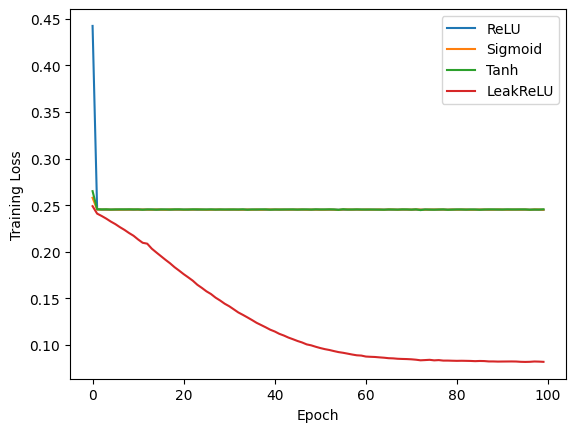

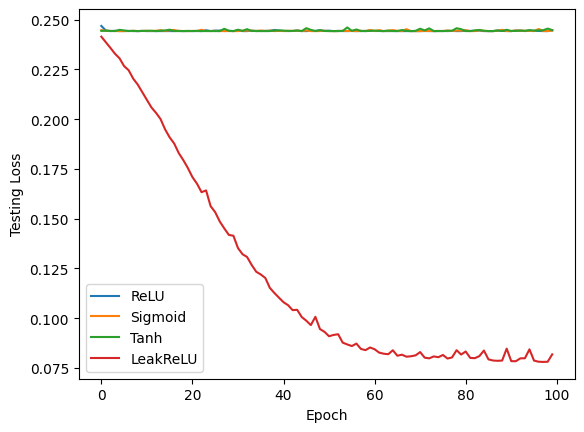

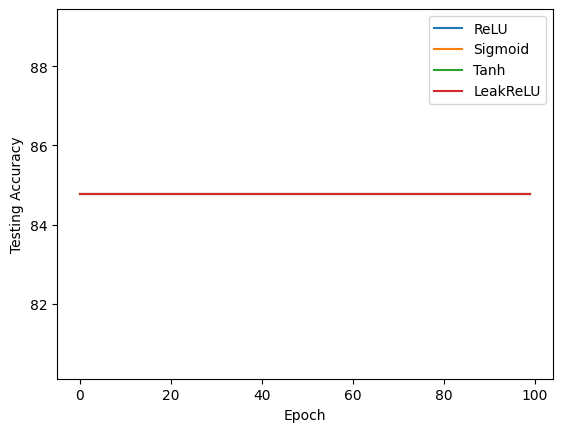

In [247]:
import matplotlib.pyplot as plt
 
# Plot the training loss
plt.figure()
for name, data in results.items():
    plt.plot(data['train_loss_history'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()
 
# Plot the testing loss
plt.figure()
for name, data in results.items():
    plt.plot(data['test_loss_history'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.legend()
plt.show()
 
# Plot the testing accuracy
plt.figure()
for name, data in results.items():
    plt.plot(data['test_accuracy_history'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.show()